In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./creditcard.csv")

In [3]:
data.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
88205,62036.0,-1.772494,2.085666,1.493984,4.463394,-0.030759,0.486878,0.277026,-0.024419,-0.609166,...,-0.126022,0.391245,-0.107061,0.431968,-0.307227,0.260360,-0.210279,-0.019836,2.47,0
199586,133037.0,0.105772,1.013053,-0.987352,-0.083746,0.186286,-1.142135,0.560521,0.251837,-0.393642,...,0.398583,1.052824,-0.025088,-0.002898,-0.309937,-0.175135,-0.083515,-0.054543,37.11,0
240121,150434.0,-0.165132,0.330968,-0.202585,3.023120,2.283134,0.178817,0.231238,0.275751,-1.484278,...,0.036216,-0.229980,0.576690,-0.024008,-2.158266,-0.635664,0.315442,0.379122,2.65,0
91346,63424.0,-0.531320,0.667302,1.858070,-0.530679,0.303545,0.077263,0.457680,0.113372,0.413450,...,0.038623,0.285025,-0.167621,-0.445520,-0.298149,-0.788482,0.200173,0.181861,9.99,0
35904,38316.0,1.260916,0.037672,0.287275,-0.119933,-0.369194,-0.719604,-0.023264,-0.116264,0.187511,...,-0.203562,-0.541265,0.141470,0.131399,0.102184,0.876311,-0.069907,0.000729,1.00,0


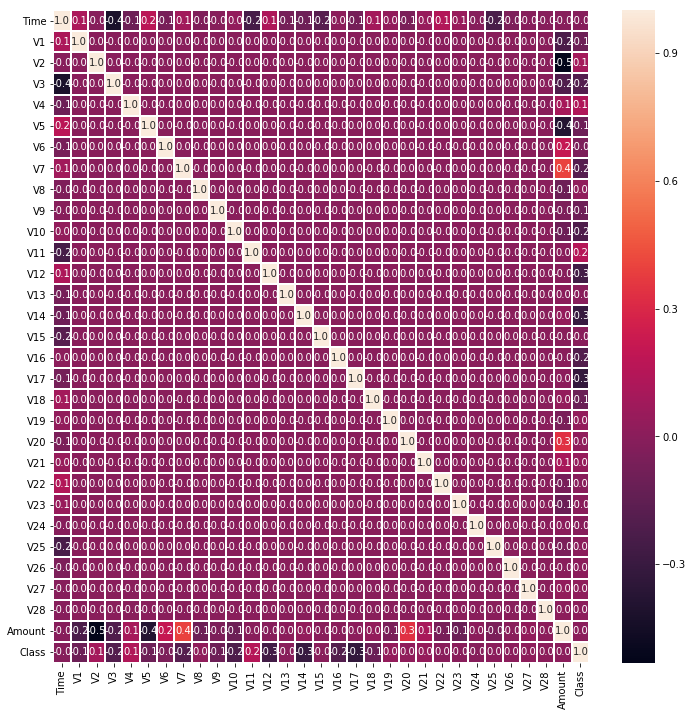

In [4]:
_ = plt.figure(figsize=(12,12))
_ = sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidths=1)
plt.show()

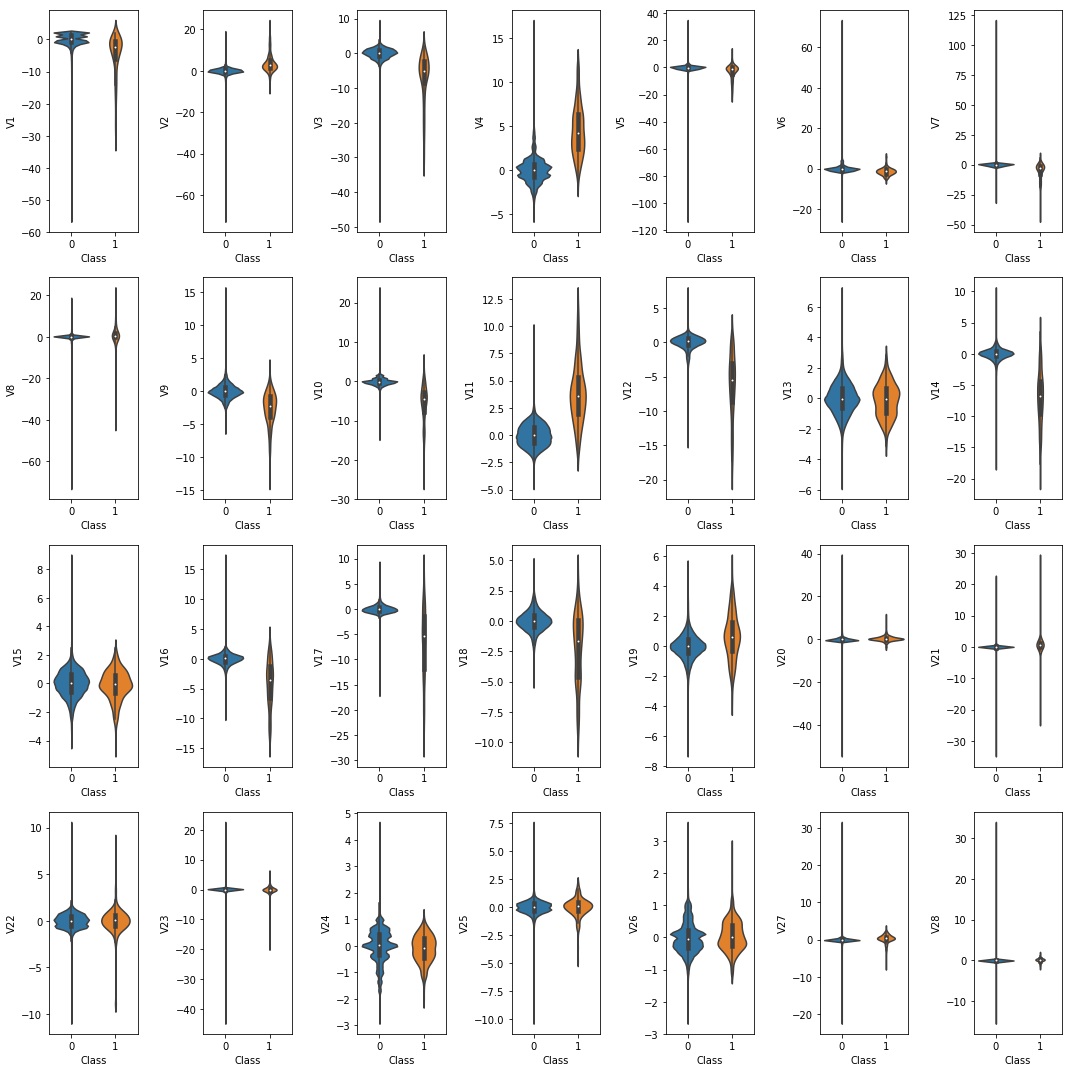

In [5]:
%matplotlib inline
_ = plt.figure(figsize=(15,15))
for i in range(1,29):
    _ = plt.subplot(4,7,i)
    _ = sns.violinplot(x="Class", y="V%d" % i, data=data)
plt.tight_layout()

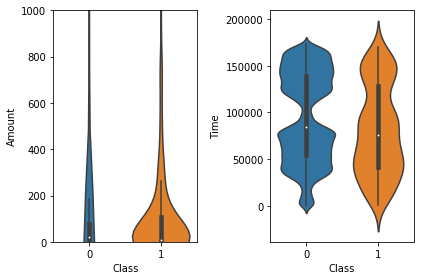

In [6]:
plt.subplot(121)
_ = sns.violinplot(x="Class", y="Amount", data=data)
_ = plt.ylim((0, 1000))
_ = plt.subplot(122)
_ = sns.violinplot(x="Class", y="Time", data=data)
plt.tight_layout()

In [7]:
data[(data.Class == 1)].shape

(492, 31)

In [8]:
dummy_cols = ["V%d" % i for i in [3,4,9,10,11,12,13,16,17,18]]
dummy_vals = []
for col in dummy_cols:
    num = int(data[col].max() - data[col].min())
    dummy_vals.append(pd.cut(data[col], bins=num, labels=[i for i in range(num)]))
cut_cols = pd.concat(dummy_vals, axis=1)

In [9]:
new_data = data.copy()
new_data[dummy_cols] = cut_cols

In [10]:
undersample_data = pd.concat([new_data[new_data.Class == 0].sample(500), new_data[new_data.Class == 1]])

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier

X_undersample_train, X_undersample_test, y_undersample_train, y_undersample_test = train_test_split(
    undersample_data.drop(columns=["Class"]),
    undersample_data.Class,
    test_size=0.2,
    random_state=42)

data_undersample = {
    "X_train": X_undersample_train,
    "X_test": X_undersample_test,
    "y_train": y_undersample_train,
    "y_test": y_undersample_test
}

In [35]:
def train(est, X_train=None, X_test=None, y_train=None, y_test=None):
    #print(X_train is None, X_test is None , y_train is None, y_test is None)
    if (X_train is None) or (X_test is None) or (y_train is None) or (y_test is None):
        return
    _ = est.fit(X_train, y_train)
    
    if hasattr(est, "best_estimator_"):
        print(est.best_estimator_)
    
    proba = est.predict_proba(X_test)[:,1]
    result = est.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    recall = recall_score(y_test, result)
    precision = precision_score(y_test, result)
    
    _ = plt.plot(fpr, tpr, 'r--', label="auc: %.2f\nrecall: %.2f\npresion: %.2f" % (auc, recall, precision))
    _ = plt.plot([0,1],[0,1], 'k--')
    _ = plt.legend()
    plt.show()

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


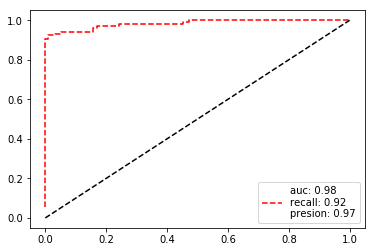

In [36]:
train(
    GridSearchCV(
        LogisticRegression(penalty='l1'),
        param_grid={"C": [0.1,1,10,50,100]},
        cv=10,
        scoring="recall"), **data_undersample)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


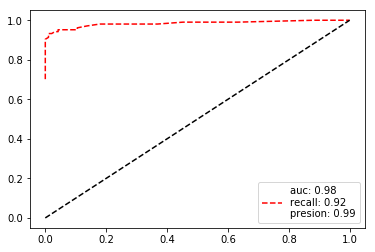

In [37]:
train(
    GridSearchCV(
        RandomForestClassifier(n_jobs=4),
        param_grid={
            "n_estimators": [10, 20, 30, 50],
            "max_depth": [3, 8, 15, 18]
        },
        cv=10,
        scoring="recall"), **data_undersample)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=["Class"]),
    data.Class,
    test_size=0.2,
    random_state=42)

data_splitted = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test
}

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


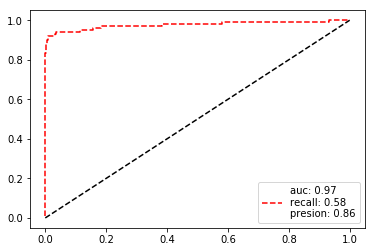

In [51]:
train(
    GridSearchCV(
        LogisticRegression(n_jobs=4, penalty='l1'),
        param_grid={"C": [0.1, 1, 10, 50, 100]},
        cv=10,
        scoring="recall"), **data_splitted)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


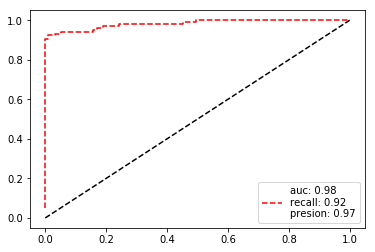

In [52]:
train(
    GridSearchCV(
        LogisticRegression(n_jobs=4, penalty='l1'),
        param_grid={"C": [0.1, 1, 10, 50, 100]},
        cv=10,
        scoring="recall"), **data_undersample)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


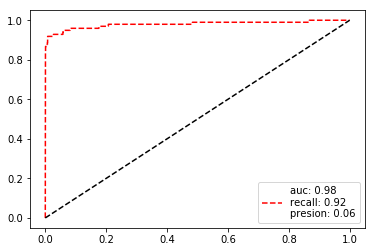

In [53]:
train(
    GridSearchCV(
        LogisticRegression(n_jobs=4, penalty='l1', class_weight="balanced"),
        param_grid={"C": [0.1, 1, 10, 50, 100]},
        cv=10,
        scoring="recall"), **data_splitted)

LogisticRegression(C=50, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


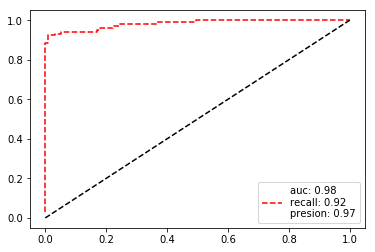

In [54]:
train(
    GridSearchCV(
        LogisticRegression(n_jobs=4, penalty='l1', class_weight="balanced"),
        param_grid={"C": [0.1, 1, 10, 50, 100]},
        cv=10,
        scoring="recall"), **data_undersample)